# 04 - Cluster Analysis and Visualization

This notebook focuses on results. It assumes that have already ran the pipeline and have a processed file.

In this notebook we will
- Interpret the final clusters using feature profiles and distributions
- Compare **feature relationships** within clusters and how they are correlated
- Identify which features most strongly differentiate clusters
- Compare the pipeline's final clustering (which is k=2) with a different k value
- Connect clusters to human labels

In [36]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

seaborn.set(style="whitegrid")


PROCESSED_PATH = Path("..") / "data" / "processed" / "spotify_tracks_with_clusters.csv"
FIGURES_DIR = Path("..") / "reports" / "figures"

df = pd.read_csv(PROCESSED_PATH)
df.head()




,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,cluster
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic,1
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic,0
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic,0
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic,0
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic,0


## 1) Clustering data

In [5]:
n_rows = len(df)
n_clusters = df["cluster"].nunique()
sizes = df["cluster"].value_counts().sort_index()

print(f"Rows in clustered dataset: {n_rows:,}")
print(f"Number of clusters in saved output: {n_clusters}")
sizes

Rows in clustered dataset: 114,000
Number of clusters in saved output: 2


cluster
0    29020
1    84980
Name: count, dtype: int64

## 2) Cluster means and strongest differentiators

In [6]:
audio_features = [
    "danceability", "energy", "loudness", "speechiness", "acousticness",
    "instrumentalness", "liveness", "valence", "tempo", "duration_ms"
]
# This makes sure that the audio features are actually in the columns
audio_features = [c for c in audio_features if c in df.columns] 

cluster_means = df.groupby("cluster")[audio_features].mean()
cluster_means

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
cluster,,,,,,,,,,
0,0.464513,0.318820,-14.079694,0.063688,0.653612,0.289947,0.178441,0.284379,109.138091,228316.059890
1,0.601730,0.751536,-6.271226,0.091811,0.199246,0.110325,0.225543,0.538845,126.590563,227931.176712


In [13]:
# For k=2, we are going to show feature differences. This is Cluster1 - Cluster0
if n_clusters == 2:
    diff = (cluster_means.loc[1] - cluster_means.loc[0]).sort_values(ascending=False)
    print("Cluster 1 - Cluster 0:\n", diff)

Cluster 1 - Cluster 0:
 tempo                17.452472
loudness              7.808468
energy                0.432716
valence               0.254466
danceability          0.137217
liveness              0.047102
speechiness           0.028123
instrumentalness     -0.179623
acousticness         -0.454366
duration_ms        -384.883178
dtype: float64


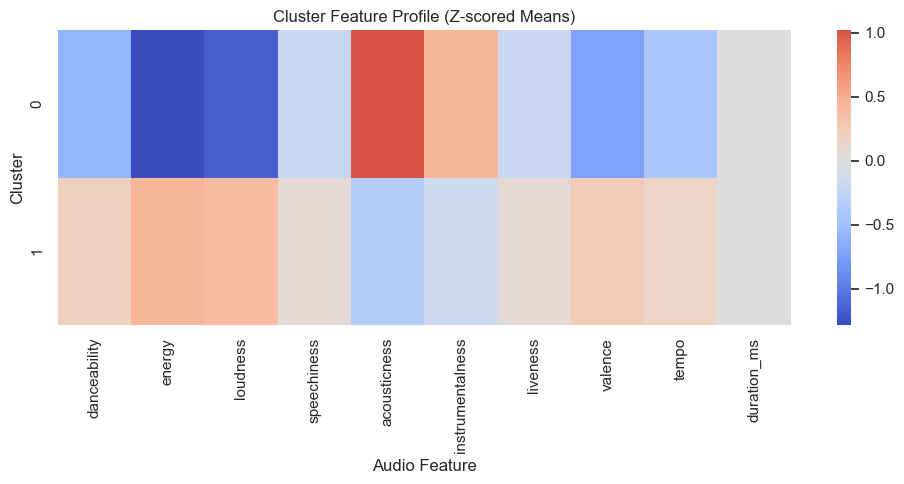

In [14]:
# Figure out which features are the ones that separate the clusters
# Compute z-scored features and then average per cluster and compare it all

scaler = StandardScaler()
x_scaled = scaler.fit_transform(df[audio_features].values)
df_z = pd.DataFrame(x_scaled, columns=audio_features)
df_z["cluster"] = df["cluster"].values

cluster_zmeans = df_z.groupby("cluster")[audio_features].mean()

plt.figure(figsize=(10,5))
seaborn.heatmap(cluster_zmeans, center=0, cmap="coolwarm")
plt.title("Cluster Feature Profile (Z-scored Means)")
plt.xlabel("Audio Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

So with the heatmap above, positive values mean that the feature is a higher determining factor in the cluster separation, whereas negative values mean that the feature is a lower determining factor in cluster separation.

By looking at the heatmap, we can see that the top three determining features are acousticness, loudness, and energy. We can also see that duration_ms had no impact on the cluster. Lastly, we can see that speechiness and liveness are lower than average features in determining the clusters.

## 3) Distributions

Do clusters overlap with each other or are they separate?

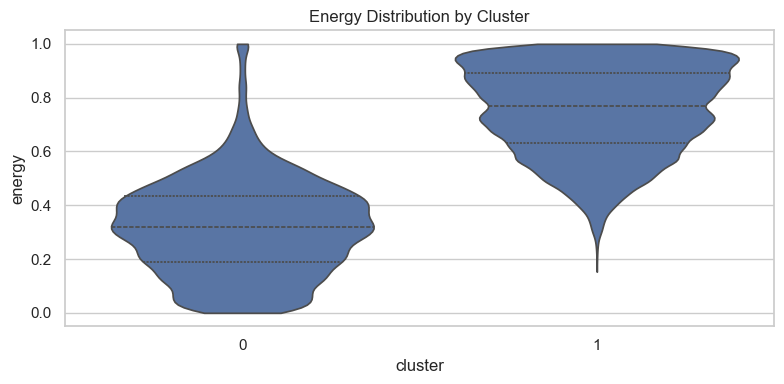

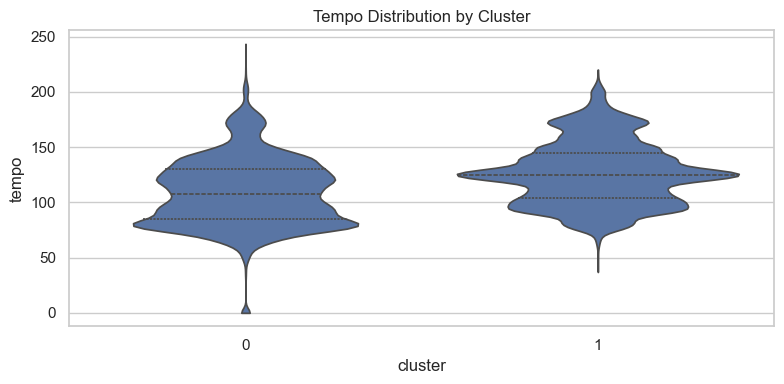

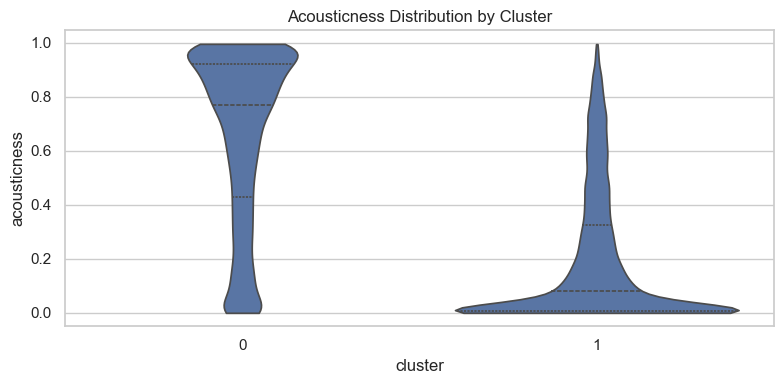

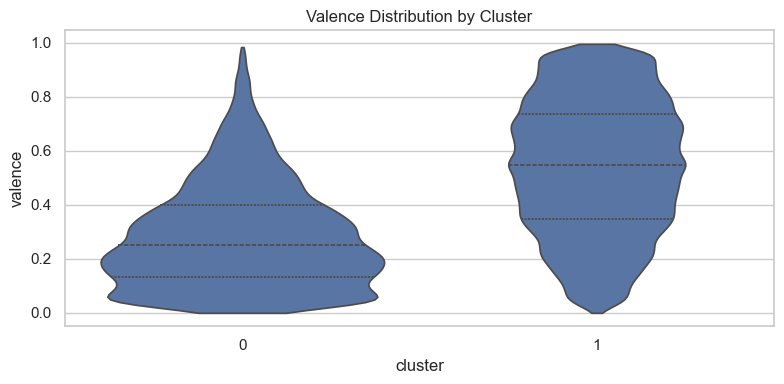

In [15]:
key_features = [c for c in ["energy", "tempo", "dancability", "acousticness", "valence"] if c in df.columns]

for col in key_features:
    plt.figure(figsize=(8,4))
    seaborn.violinplot(data=df, x="cluster", y=col, inner="quartile", cut=0)
    plt.title(f"{col.capitalize()} Distribution by Cluster")
    plt.tight_layout()
    plt.show()

With the violin plots, we can see how different features overlap with each other or if they are separated. If they are separated and don't overlap (acousticness and energy), then we can say that they separate the clusters well. 

However, if they overlap, then we can say that they do not separate the clusters well and that they are not a strong determining factor on their own.

## 4) Feature relationships within a cluster

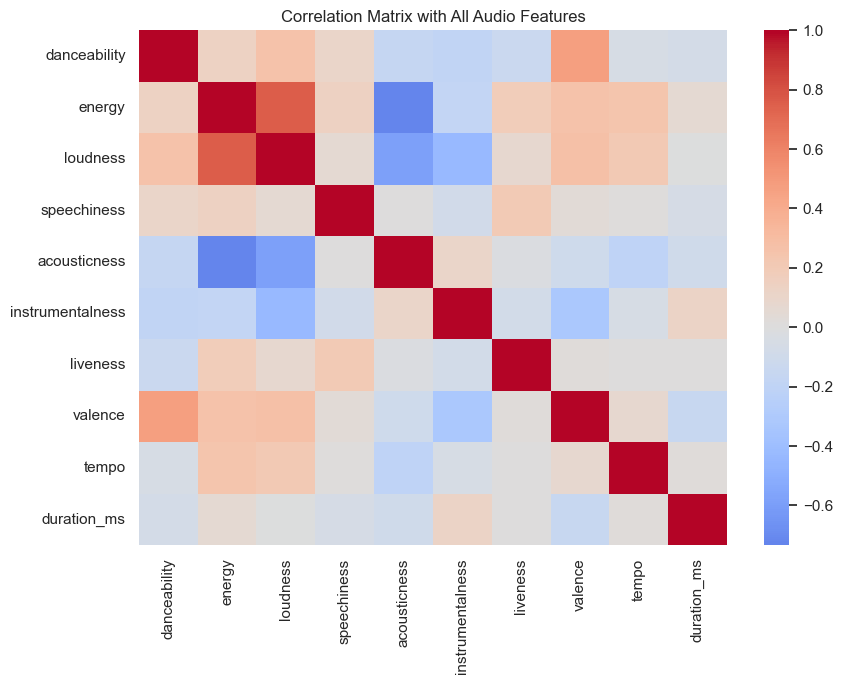

In [16]:
correlation_all = df[audio_features].corr()

plt.figure(figsize=(9,7))
seaborn.heatmap(correlation_all, cmap="coolwarm", center=0)
plt.title("Correlation Matrix with All Audio Features")
plt.tight_layout()
plt.show()


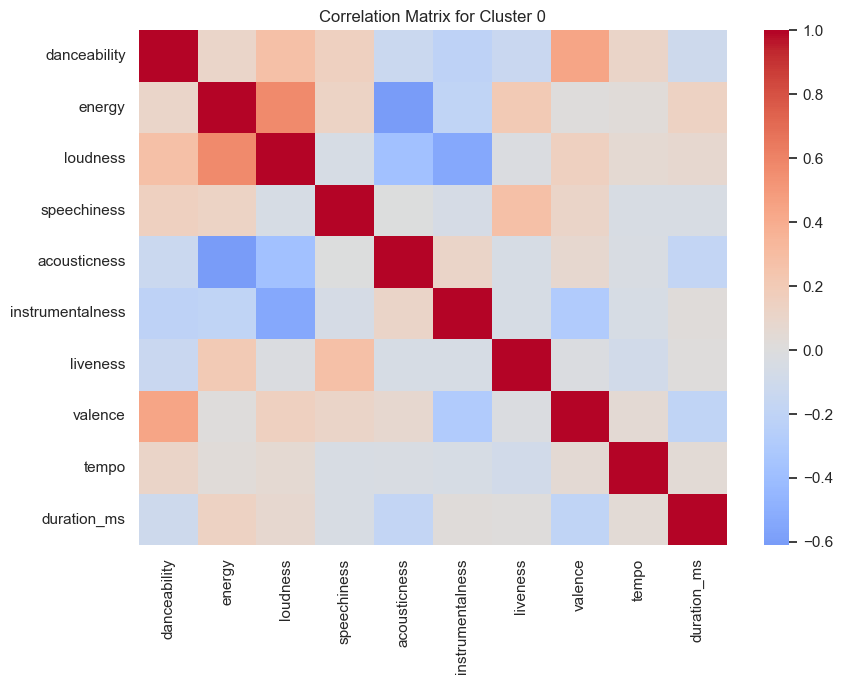

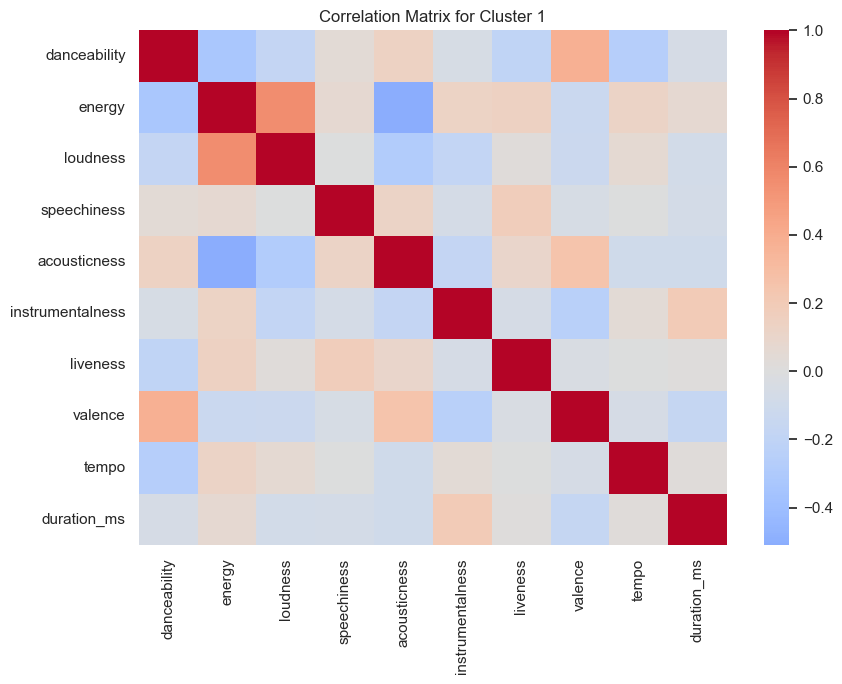

In [19]:
# Now we show the correlation matrices by their cluster to see the structure inside each of them
for cluster in sorted(df["cluster"].unique()):
    correlation_cluster = df[df["cluster"] == cluster][audio_features].corr()
    plt.figure(figsize=(9,7))
    seaborn.heatmap(correlation_cluster, cmap="coolwarm", center=0)
    plt.title(f"Correlation Matrix for Cluster {cluster}")
    plt.tight_layout()
    plt.show()

With the two separate correlation maps, we are able to identify which features are related inside of each cluster and how they differ from each other.

Patterns
- We can that energy and loudness are strongly correlated in both clusters, which is common in music.
- Danceability and tempo differ between both clusters. This is because fast tracks aren't always more danceable.

## 5) Pairwise scatter views

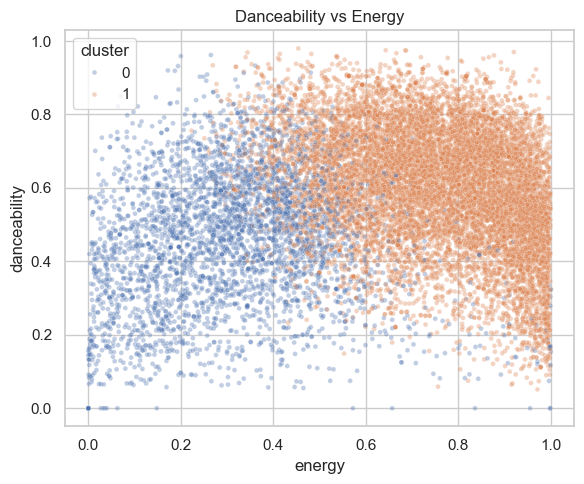

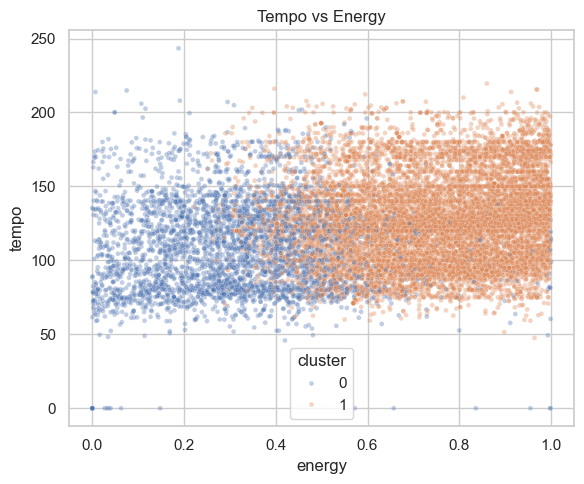

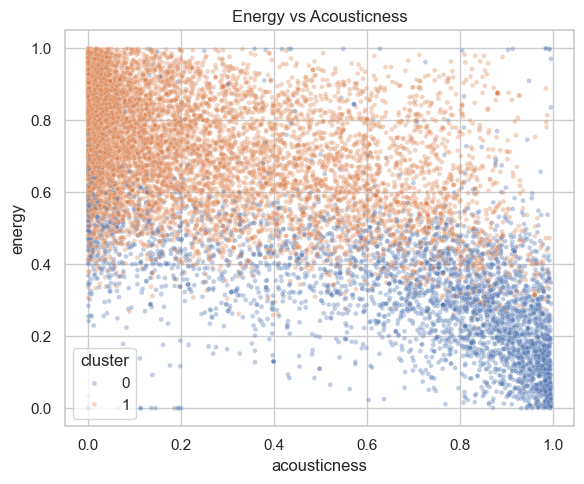

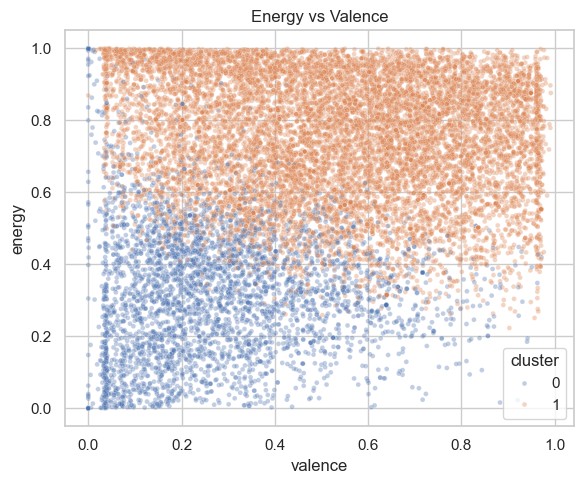

In [20]:
pairs = [
    ("energy", "danceability"),
    ("energy", "tempo"),
    ("acousticness", "energy"),
    ("valence", "energy"),
]

# This just picks the pairs above where both are in the final columns
pairs = [(x,y) for x, y in pairs if x in df.columns and y in df.columns]

for x, y in pairs:
    plt.figure(figsize=(6,5))
    seaborn.scatterplot(data=df.sample(min(15000, len(df)), random_state=42), x=x, y=y, hue="cluster", alpha=0.35, s=12)
    plt.title(f"{y.capitalize()} vs {x.capitalize()}")
    plt.tight_layout()
    plt.show()

We can see how different features compare to each other and how they separate from one another. These all show a big differential and are determining factors in clusters due to their split.

## 6) Connect clusters to labels

In [25]:
# Genre composition
# These are the top genres per cluster

genre = (
    df.groupby("cluster")["track_genre"]
    .value_counts(normalize=True)
    .rename("proportion")
    .reset_index()
)

top_genres = (
    genre.sort_values(["cluster", "proportion"], ascending=[True, False])
    .groupby("cluster")
    .head(8)
)
print(f"The top genres per cluster:\n{top_genres}.")

The top genres per cluster:
     cluster    track_genre  proportion
0          0          sleep    0.034080
1          0        new-age    0.031702
2          0        ambient    0.031564
3          0      classical    0.031392
4          0          opera    0.029428
5          0        romance    0.029083
6          0         disney    0.026051
7          0         guitar    0.024397
114        1      hardstyle    0.011756
115        1          party    0.011732
116        1          forro    0.011709
117        1      reggaeton    0.011697
118        1          house    0.011685
119        1  drum-and-bass    0.011638
120        1         reggae    0.011626
121        1            edm    0.011614.


In [29]:
# Popularity summary by cluster

# Check to make sure it exists in the columns
if "popularity" in df.columns:
    pop_stats = df.groupby("cluster")["popularity"].agg(["count", "mean", "median", "std", "min", "max"])
    print(pop_stats)

         count       mean  median        std  min  max
cluster                                               
0        29020  32.449414    34.0  21.592623    0   94
1        84980  33.508014    35.0  22.537016    0  100


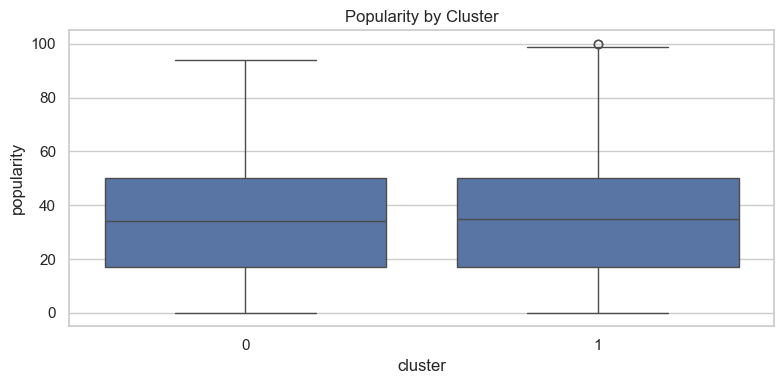

In [28]:
if "popularity" in df.columns:
    plt.figure(figsize=(8,4))
    seaborn.boxplot(data=df, x="cluster", y="popularity")
    plt.title("Popularity by Cluster")
    plt.tight_layout()
    plt.show()

The two clusters have nearly the same popularity distributions (mean & median differ by about 1 and spread is similar). So popularity is not what separates these clusters. Because popularity and genre were not used for clustering, we are only using them to understand more about our dataset. The genre breakdown shows that cluster 0 is associated with calmer styles such as sleep/ambient/classical, whereas cluster 1 is more associatewd with higher-energy dance styles such as hardstyle/house/EDM. This is consistent with the energy differences before even though no single genre dominates a cluster. 

## 7) Final k vs other k values

In [32]:
# Going to compare the final k value to an alternative
# This is just to get an understanding of other k values and how they are related
k_saved = int(df["cluster"].nunique())
k_alt = 8

# Prepare a scaled feature matrix
x = df[audio_features].values
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

def sum_labels(labels, k):
    silhouette = silhouette_score(x_scaled, labels, sample_size=min(10000, len(labels)), random_state=42)
    df_temp = pd.DataFrame(x_scaled, columns=audio_features)
    df_temp["cluster"] = labels
    zmeans = df_temp.groupby("cluster")[audio_features].mean()
    return silhouette, zmeans

# We save the labels
labels_saved = df["cluster"].values
silhouette_saved, zmeans_saved = sum_labels(labels_saved, k_saved)
# We find out alternative labels
kmeans_alt = KMeans(n_clusters=k_alt, random_state=42, n_init=10)
labels_alt = kmeans_alt.fit_predict(x_scaled)
silhouette_alt, zmeans_alt = sum_labels(labels_alt, k_alt)

pd.DataFrame([
    {"k": k_saved, "silhouette:": silhouette_saved},
    {"k": k_alt, "silhouette:": silhouette_alt},
])

,k,silhouette:
0,2,0.234385
1,8,0.181847


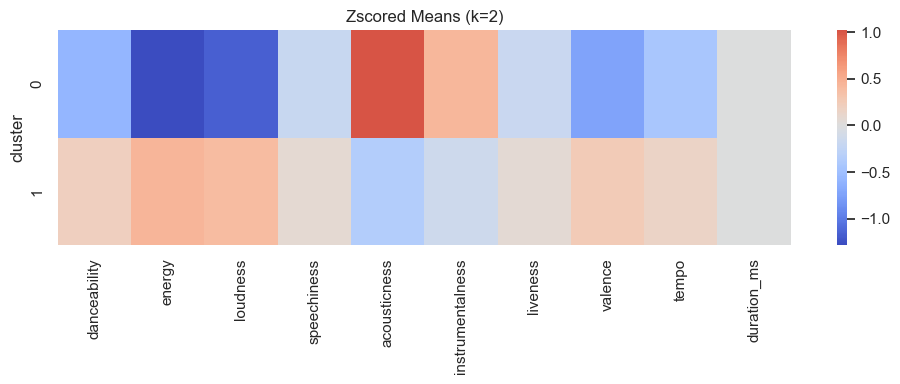

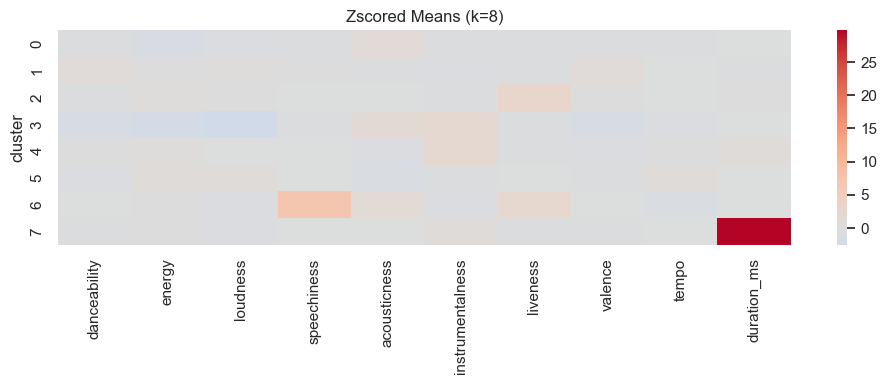

In [33]:
# We are going to compare the z-scored mean profiles side by side using heatmaps
plt.figure(figsize=(10,4))
seaborn.heatmap(zmeans_saved, center=0, cmap="coolwarm")
plt.title(f"Zscored Means (k={k_saved})")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
seaborn.heatmap(zmeans_alt, center=0, cmap="coolwarm")
plt.title(f"Zscored Means (k={k_alt})")
plt.tight_layout()
plt.show()

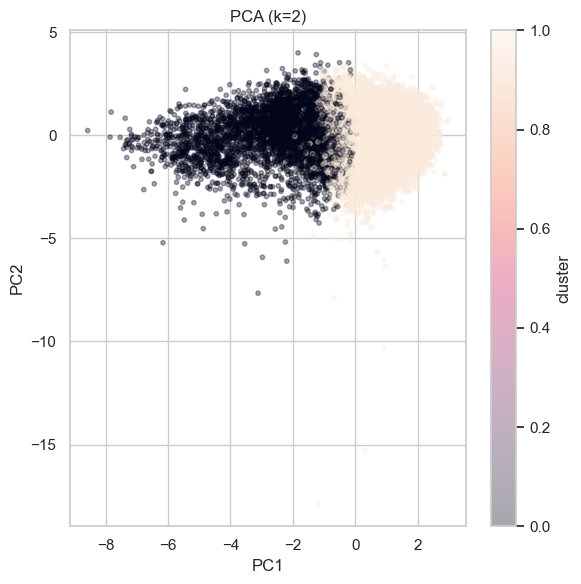

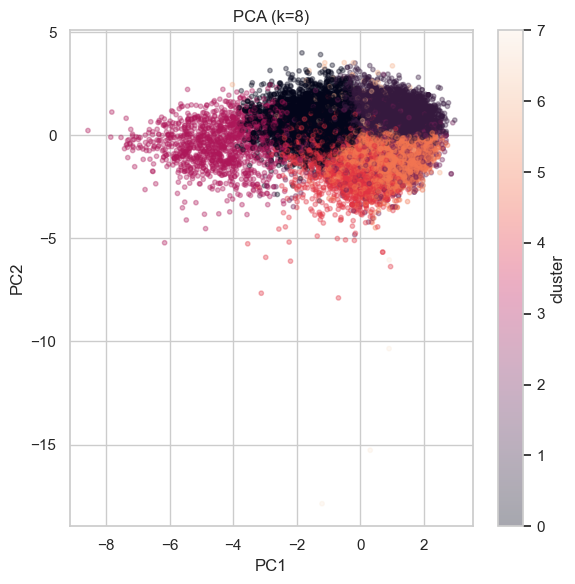

In [37]:
# Projection colored by both labels

pca = PCA(n_components=2, random_state=42)
x_pca = pca.fit_transform(x_scaled)

sample_index = np.random.RandomState(42).choice(len(df), size=min(20000, len(df)), replace=False)

plt.figure(figsize=(6, 6))
scatter = plt.scatter(x_pca[sample_index, 0], x_pca[sample_index, 1], c=labels_saved[sample_index], s=10, alpha=0.35)
plt.title(f"PCA (k={k_saved})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="cluster")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
scatter = plt.scatter(x_pca[sample_index, 0], x_pca[sample_index, 1], c=labels_alt[sample_index], s=10, alpha=0.35)
plt.title(f"PCA (k={k_alt})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="cluster")
plt.tight_layout()
plt.show()


These comparisons help show why our silhouette score is better at k=2 instead of k=8. It prefers smaller k values and produces a broad split between different features such as low-energy and high-energy. Although a larger silhouette can create more detailed and interpretable subgroups, it reduces the silhouette score.

## Conclusion

This notebooks takes the final clustering results and changes them into clear takeaways. Using cluster-level summaries, we can see which audio characteristics most strongly differentiate the clusters. We then examine how features relate to each other within clusters through correlation heatmaps and scatter views to understand the structure. Finally, we bring in labels such as genre and popularity to see whether clusters align with genre boundaries, and we compare the saved clustering (k=2) to an alternative k value (k=8) to see whether it produces more meaningful subgroups.

Overall, this notebook summarizes our main findings and how it relates to their real world labels.